In [ ]:
!pip install -qq scikit-image captum Pillow pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00


#### Import Impportant **Libraries**.

In [ ]:
import os
import random
import re
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import requests

# Google
from google.colab import drive
drive.mount('/content/drive/')

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Pydicom - Load DCM Files
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut

# Scikit-image
from skimage.io import imread

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import resnet18

# Captum
import captum
from captum.attr import Saliency, LayerGradCam, Occlusion
from captum.attr import visualization as viz

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load the dataset of Lumbar Spinal Cord MRIs


In [ ]:
# Load the Google Sheet using Pandas.
sheet_id = "1iVB7gvQdXeJ_N0vvYxWYmQvWT_Nwnb8CFsdH-rV6YGs"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [ ]:
df = pd.read_csv(url)

In [ ]:
df.head()

,patient_id,path,new_path
0,1,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/1/
1,2,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/2/
2,3,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/3/
3,4,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/4/
4,5,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/5/


In [ ]:
# load all the MRIs on the basis of patient_ids.

mri_dcm = []
mri_dcm.clear()
dataset_path = '/content/drive/MyDrive/thesis/Datasets/lumbar_spinal_cord_mri_datasets/datasets/'
dataset_list = list(Path(dataset_path).rglob("*.ima" ))
paths = list(df['new_path'])

for fileName in dataset_list:
  try:
    file_size = os.path.getsize(fileName)
    if file_size > 0:
      for i in paths:
        if i in str(fileName):
          patient_id = str(re.findall('\d+',i)[0])
          new_data = {'filePath': str(fileName), 'patient_id': patient_id}
          mri_dcm.append(new_data)
  except FileNotFoundError as e:
    continue

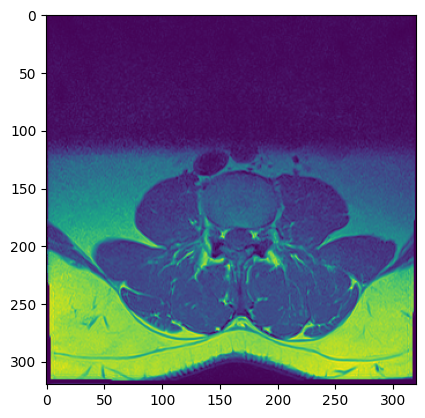

In [ ]:
# Load and show a single MRI

ds = dicom.dcmread(mri_dcm[0]['filePath'])

plt.imshow(ds.pixel_array)

### Show all the different angles randomly of a single patient.

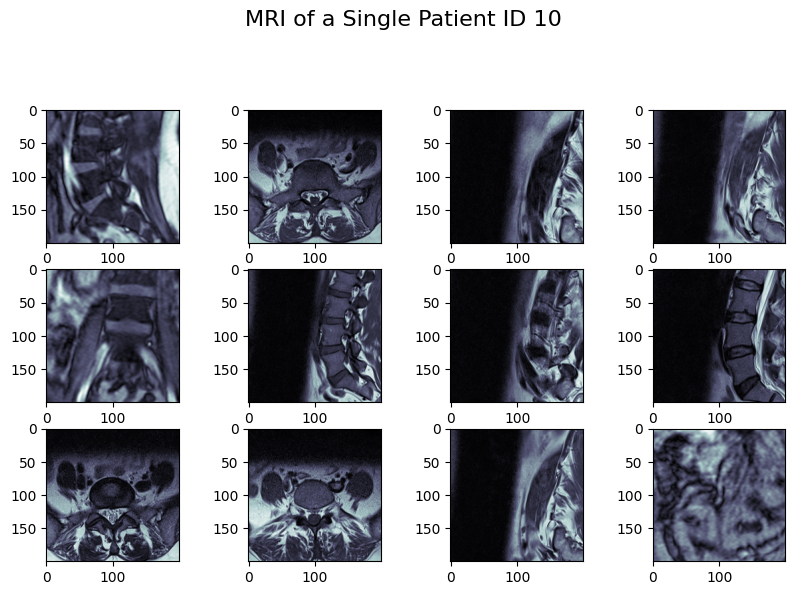

In [ ]:
# Show all the different angles randomly of a single patient.

randomly_single_patient_mri = []
random_no = 12
patient_id_ = 10
randomly_single_patient_mri.clear()

def show_all_spinal_cord_mris(images: list, cmap, rows=5, columns=4, labels=None, figure_size: tuple = (10, 10) ):
  """
    show all the spinal cord MRI images in a single row
  """
  w = 5
  h = 5
  fig = plt.figure(figsize=figure_size)
  fig.suptitle(f'MRI of a Single Patient ID {patient_id_}', fontsize=16)
  columns = columns
  rows = rows
  for i in range(0, len(images)):

      if dicom.dataset.FileDataset == type(images[i]):
        midrow = images[i].Rows // 2
        midcol = images[i].Columns // 2
        pixel_values = images[i].pixel_array[midrow-100:midrow+100, midcol-100:midcol+100]
        hu = apply_modality_lut(pixel_values, images[i])
        fig.add_subplot(rows, columns, i+1)
        out = apply_voi_lut(hu, images[i], index=0)
        plt.imshow(out, cmap=cmap)
      else:
        midrow = images[i].shape[0] // 2
        midcol = images[i].shape[1] // 2
        pixel_values = images[i][midrow-100:midrow+100, midcol-100:midcol+100]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(pixel_values, cmap=cmap)
        if labels is not None:
         plt.title(labels[i])

  plt.show()

for mri_images in mri_dcm:
  if mri_images['patient_id'] == str(patient_id_):
    ds = dicom.dcmread(mri_images['filePath'])
    randomly_single_patient_mri.append(ds)

list_of_random_items = random.sample(randomly_single_patient_mri, random_no)

show_all_spinal_cord_mris(list_of_random_items[:13], cmap=plt.cm.bone)

Load the MRIs images of patients.

In [ ]:
load_mri_path = "/content/drive/MyDrive/thesis/Datasets/MRI/preprocessed"
print(len(next(os.walk(f"{load_mri_path}{os.sep}"))[1]))
length = next(os.walk(f"{load_mri_path}{os.sep}"))[1]
print(length)

19
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


Creating own Dataset `Class` to load our own datasets.

In [ ]:
class SpinalCordDataset(Dataset):
  def __init__(self, label_dir, image_size):
    self.label_dir = label_dir
    self.image_size = image_size

    self.labels = []
    # self.create_labels()
    self.create_images()

  def create_labels(self):
    file_dir_path = []

    file_path = next(os.walk(f"{self.label_dir}{os.sep}"))[1]
    for i in range(0, len(file_path)):
      for cur_path, dirs, files in os.walk(f"{self.label_dir}{os.sep}{file_path[i]}"):
        for dir in dirs:
          if 'Post-Processed' in dir:
            break
        for file in files:
          if file.endswith(".png"):
            file_dir_path.append(os.path.join(cur_path, file))

    self.labels = file_dir_path

  def create_images(self):
    path = next(os.walk(f"{self.label_dir}{os.sep}"))[1]
    image_path = []

    for i in range(0, len(path)):
      for cur_path, dirs, files in os.walk(f"{self.label_dir}{os.sep}{path[i]}"):
        for file in files:
          if file.endswith(".jpg"):
            image_path.append((os.path.join(cur_path, file), random.randint(0, 1)))

    self.labels = image_path

  def normalize_image(self, image):
    image = image.astype(np.float32) * 255 / image.max()
    image = image.astype(np.uint8)
    return image

  def normailize(self, image):
    # transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #     ])
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    image = transform(image)
    return image

  def __getitem__(self, idx):
    fpath, target = self.labels[idx]
    # fpath = self.labels[idx]
    image_array = imread(fpath, as_gray=True)
    # image_array = self.normalize_image(image_array)
    image_array = self.normailize(image_array)
    # data = torch.from_numpy(image_array)
    data = image_array.type(torch.FloatTensor)
    # data = torch.unsqueeze(data, 0)
    data = transforms.Resize((self.image_size, self.image_size))(data)

    return data, target

  def __len__(self):
    return len(self.labels)

In [ ]:
for target, target_label in enumerate(['neg', 'pos']):
  print(target, target_label)

print("\n")

for _ in range(10):
    k = random.randint(0, 1) # decide on a k each time the loop runs
    print(k)

0 neg
1 pos


0
1
1
1
1
0
1
0
1
0


Call our `Dataset` custom class.

In [ ]:
label_path = "/content/drive/MyDrive/thesis/Datasets/lumbar_spinal_cord_mri_datasets/labels/manual_label"
dataset_path = '/content/drive/MyDrive/thesis/Datasets/MRI/preprocessed'
image_size = 233
dataset = SpinalCordDataset(dataset_path, image_size)
print(type(dataset))

<class '__main__.SpinalCordDataset'>


### Spliting the `Dataset` Randomly

For this we are splitting our dataset into training, validation, and testing by 70%, 10% and 20% respectively.

In [ ]:
train_fraction = 0.7
val_fraction = 0.1
test_fraction = 0.2
dataset_size = len(dataset)
print(dataset_size)

num_train = int(train_fraction * dataset_size)
num_validation = int(val_fraction * dataset_size)
num_test = dataset_size - num_train - num_validation

print(num_train, num_validation, num_test)

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
                                 dataset, [num_train, num_validation, num_test],
                                 generator=torch.Generator().manual_seed(42))
print(type(train_dataset))
print(len(train_dataset), len(validation_dataset), len(test_dataset))


1728
1209 172 347
<class 'torch.utils.data.dataset.Subset'>
1209 172 347


Check do we conneted with the GPU or not.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Dataloaders

It is hard for us to train our model by giving it one by one images in each epoch. So, this procedure is quite slow, for this we need to make sure that in each epoch we will pass a batch of images instead of a single image. That is why, we are using `Dataloaders` to load our data in `batches`.

In [ ]:
train_batch_size = 200
eval_batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size)

In [ ]:
len(train_dataloader), len(validation_dataloader), len(test_dataloader)

(7, 18, 35)

We need to make sure that in every systems the random values must be same.

In [ ]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Build a Model

In [ ]:
class SpinalCordModel(torch.nn.Module):
  def __init__(self):
    super(SpinalCordModel, self).__init__()


In [ ]:
net = resnet18()
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net = net.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 6

We need to make a copy of our `net`, so that we can make it later.

In [ ]:
net_copy = deepcopy(net)

In [ ]:
# batch_index, inputs, targets = None, None, None
# batch_index, inputs, targets in tqdm(enumerate(train_dataloader), total=len(train_dataset) // train_batch_size)
# for batch_index, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Processing Data"):
#   print("\n")
#   print(data)
#   # inputs, targets = data
#   # inputs = inputs.to(device)
#   # targets = targets.to(device)
#   # print(batch_index, inputs, targets)
#   break
next(enumerate(train_dataloader))

(0,
 [tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            ...,
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]],
  
  
          [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            ...,
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]],
  
  
          [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.

Train a model and pass training and validation data to it.

In [ ]:
best_validation_accuracy = 0
# batch_index, inputs, targets = None, None, None

# For training visualization later
train_accs = []
val_accs = []

# training loop
for epoch in range(epochs):
  # Set a network to train mode, so that its parameters can be changed
  net.train()

  # print training info
  print("Epoch {}:".format(epoch))

  # Statistics needed to compute classification accuracy.
  # the total number of image examples trained on
  total_train_examples = 0

  # the number of examples classified correctly
  num_correct_train = 0

  # iterate over the training set once
  # for batch_index, (inputs) in tqdm(enumerate(train_dataloader), total=len(train_dataset) // train_batch_size):
  # for batch_index, inputs, targets in tqdm(enumerate(train_dataloader), total=len(train_dataset) // train_batch_size, desc="Training Process"):
  for batch_index, (inputs, targets) in tqdm(enumerate(train_dataloader), total=len(train_dataset) // train_batch_size, desc="Processing Data"):
    inputs = inputs.to(device)
    targets = targets.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    predictation = net(inputs)
    loss = criterion(predictation, targets)
    loss.backward()
    optimizer.step()

    _, predicted_class = predictation.max(1)
    total_train_examples += predicted_class.size(0)
    num_correct_train += predicted_class.eq(targets).sum().item()

  train_acc = num_correct_train / total_train_examples
  print("Training accuracy: {}".format(train_acc))
  train_accs.append(train_acc)

  total_val_examples = 0
  num_correct_val = 0

  net.eval()

  with torch.no_grad():
    for batch_index, (inputs, targets) in tqdm(enumerate(validation_dataloader), total=len(validation_dataset) // eval_batch_size, desc="validation"):
      inputs = inputs.to(device)
      targets = targets.to(device)

      predictation = net(inputs)
      _, predicted_class = predictation.max(1)
      total_val_examples += predicted_class.size(0)
      num_correct_val += predicted_class.eq(targets).sum().item()

  val_acc = num_correct_val / total_val_examples
  print("Validation accuracy: {}".format(val_acc))
  val_accs.append(val_acc)

  if val_acc > best_validation_accuracy:
    best_validation_accuracy = val_acc
    # torch.save(net.state_dict(), "best_model.pth")
    print("validation accuracy improved, saving model")
    net_copy = deepcopy(net)

Epoch 0:


Processing Data: 7it [12:07, 103.95s/it]


Training accuracy: 0.3986765922249793


validation: 18it [00:59,  3.31s/it]


Validation accuracy: 0.5755813953488372
validation accuracy improved, saving model
Epoch 1:


Processing Data: 7it [07:48, 66.89s/it]


Training accuracy: 0.5012406947890818


validation: 18it [00:18,  1.02s/it]


Validation accuracy: 0.5872093023255814
validation accuracy improved, saving model
Epoch 2:


Processing Data: 7it [07:48, 66.98s/it]


Training accuracy: 0.5070306038047974


validation: 18it [00:18,  1.02s/it]


Validation accuracy: 0.5348837209302325
Epoch 3:


Processing Data: 7it [07:52, 67.46s/it]


Training accuracy: 0.5161290322580645


validation: 18it [00:19,  1.06s/it]


Validation accuracy: 0.5523255813953488
Epoch 4:


Processing Data: 7it [07:31, 64.50s/it]


Training accuracy: 0.5260545905707196


validation: 18it [00:17,  1.02it/s]


Validation accuracy: 0.42441860465116277
Epoch 5:


Processing Data: 7it [07:43, 66.22s/it]


Training accuracy: 0.5128205128205128


validation: 18it [00:18,  1.01s/it]

Validation accuracy: 0.5581395348837209


Saving a Model

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/thesis/Model/proposed_model.pth"

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/thesis/Model/proposed_model.pth"
torch.save(net.state_dict(), SAVE_PATH)

Plot the training evolution prediction accuracy over time

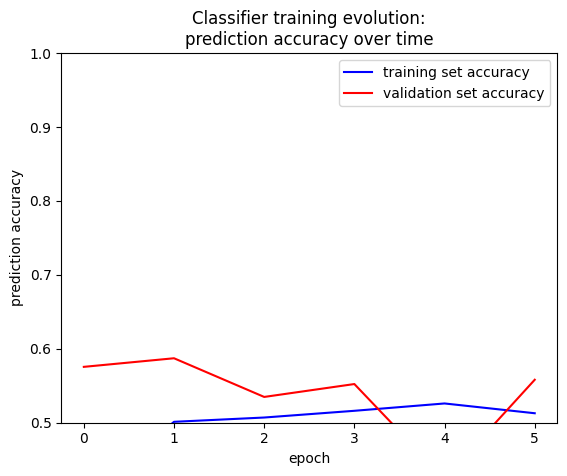

In [ ]:
epochs_list = list(range(epochs))

plt.figure()
plt.plot(epochs_list, train_accs, 'b-', label='training set accuracy')
plt.plot(epochs_list, val_accs, 'r-', label='validation set accuracy')
plt.xlabel('epoch')
plt.ylabel('prediction accuracy')
plt.ylim(0.5, 1)
plt.title('Classifier training evolution:\nprediction accuracy over time')
plt.legend()
plt.show()

In [ ]:
# net.load_state_dict(torch.load(SAVE_PATH, weights_only=True), strict=False)

Example Images:


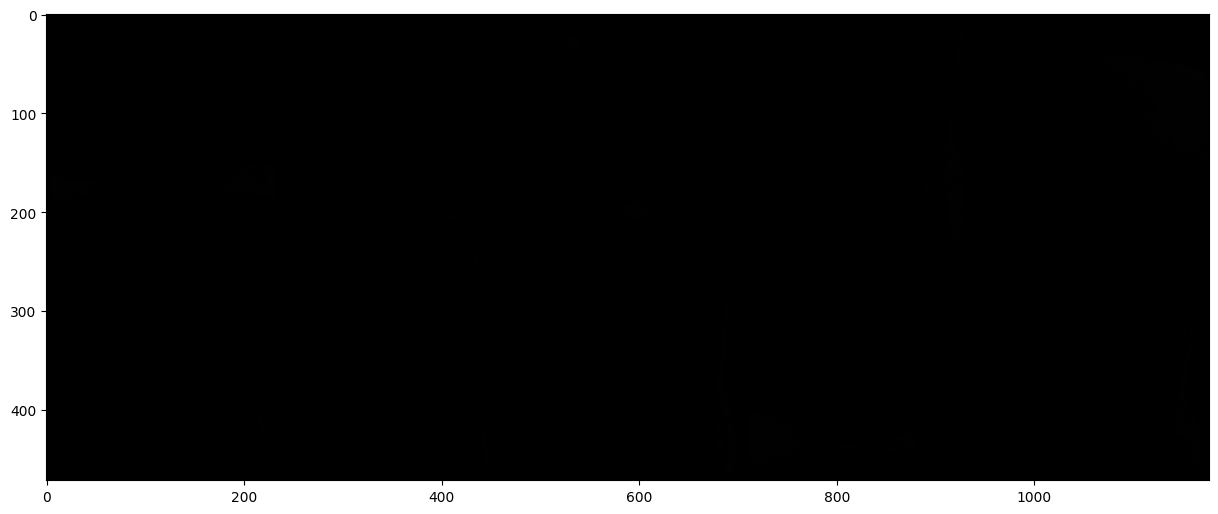

Target labels:
[1, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Classifier predictions:
[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Test set accuracy: 0.4899135446685879
154 true positive classifications, 155 false positive classifications


In [ ]:
# for data visualization
from torchvision.utils import make_grid

# helper function for plotting a batch of images
def plot_imgbatch(imgs):
    imgs = imgs.cpu()
    imgs = imgs.type(torch.IntTensor)
    plt.figure(figsize=(15, 3*(imgs.shape[0])))
    grid_img = make_grid(imgs, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

total_test_examples = 0
num_correct_test = 0

# true and false positive counts
false_pos_count = 0
true_pos_count = 0

# visualize a random batch of data with examples
num_viz = 10
viz_index = random.randint(0, len(test_dataset)//eval_batch_size)

# see how well the final trained model does on the test set
with torch.no_grad(): # don't save parameter gradients/changes since this is not for model training
		for batch_index, (inputs, targets) in enumerate(test_dataloader):
			# make predictions
			inputs = inputs.to(device)
			targets = targets.to(device)
			predictions = net_copy(inputs)

			# compute prediction statistics
			_, predicted_class = predictions.max(1)
			total_test_examples += predicted_class.size(0)
			num_correct_test += predicted_class.eq(targets).sum().item()

			# thanks to
			#   https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
			confusion_vector = predicted_class / targets
			num_true_pos = torch.sum(confusion_vector == 1).item()
			num_false_pos = torch.sum(confusion_vector == float('inf')).item()

			true_pos_count += num_true_pos
			false_pos_count += num_false_pos

			# plot predictions
			if batch_index == viz_index:
				print('Example Images:')
				plot_imgbatch(inputs[:num_viz])
				print('Target labels:')
				print(targets[:num_viz].tolist())
				print('Classifier predictions:')
				print(predicted_class[:num_viz].tolist())



# get total results
# total prediction accuracy of network on test set
test_acc = num_correct_test / total_test_examples
print("Test set accuracy: {}".format(test_acc))
print("{} true positive classifications, {} false positive classifications".format(true_pos_count, false_pos_count))


In [ ]:
print("Hello World")

Hello World


In [ ]:
# Model expects 200x200 1-color image
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
])

norm_transform = transforms.Normalize(mean=[0.485], std=[0.229])

image_path = 'https://i.ytimg.com/vi/1zN4yMnfDhc/hqdefault.jpg?sqp=-oaymwEmCOADEOgC8quKqQMa8AEB-AGWAoAC6AKKAgwIABABGF0gXShdMA8=&rs=AOn4CLB5rIfca1-3NMz3mNvQiWkS6BoGBw'
# image_path = f'/content/drive/MyDrive/thesis/Datasets/MRI/preprocessed/4/IMG_1.jpg'

transformed_norm = transform(Image.open(requests.get(image_path, stream=True).raw).convert('L'))
# transformed_norm = transform(image_path)
input_img = norm_transform(transformed_norm)
input_img = input_img.unsqueeze(0)

original_img = np.transpose(transformed_norm.squeeze().cpu().detach().numpy())

In [ ]:
output = net_copy(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, k=1)
pred_label_idx.squeeze()
# predicted_label =
print(f"Predicted: {prediction_score.squeeze().item()}")

Predicted: 0.507292628288269


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


(200, 200)


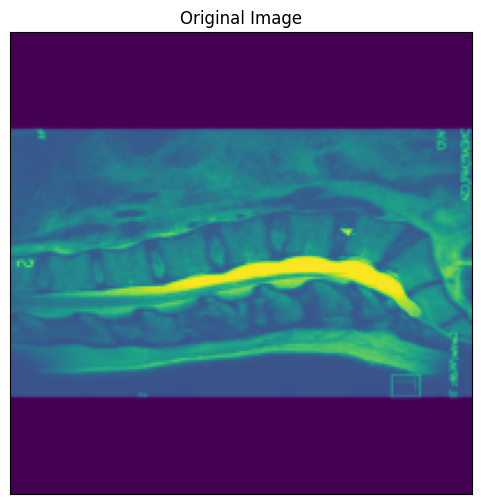

<ipython-input-26-6716fe07af33>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("plasma"))


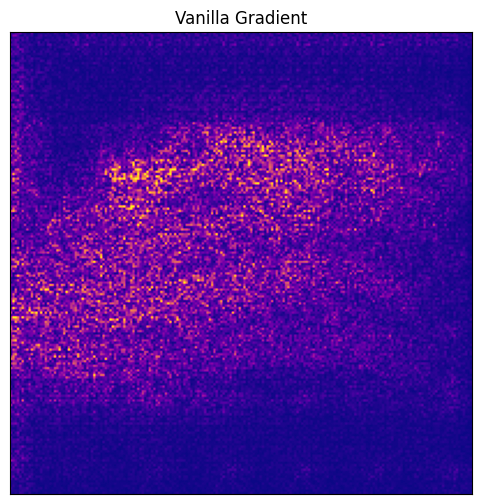

In [ ]:
# initialize the algorithm too attribute algorithm with the model.
vanilla_saliency = Saliency(net_copy)

# Ask the algorithm to attribute our output target to the most important input pixels.
attribution_vg = vanilla_saliency.attribute(input_img, target=1)
print(np.transpose(attribution_vg.squeeze().cpu().detach().numpy()).shape)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, original_img, method="original_image", title="Original Image")

# Show vanilla-gradient
_ = viz.visualize_image_attr(np.transpose(attribution_vg.cpu().detach().numpy()), \
                             original_img, \
                             method="heat_map", \
                             title="Vanilla Gradient", \
                             cmap=plt.cm.get_cmap("plasma"))

In [ ]:
# Image Masked
_ = viz.visualize_image_attr(np.transpose(attribution_vg.cpu().detach().numpy()), \
                             original_img, \
                             method="masked_image", \
                             title="Masked Image")